# Orbitrap-data-sort-bracketing

Version 1.0 (22/1/23)

A script to process cleaned Orbitrap scan data and remove outling injections

### Inputs: 
- The path to a series of 'additional_output' files from Thermo R script (v3) which contain cleaned Orbitrap data for every scan in a run
- AGC and microscan settings
- Name of internal standard, matching that used in sequence
- Name of isotope reference data  
### Additional inputs for no-M0 experiments:
- Path to internal deltas for M0 experiment for same samples
- Identity of basepeak

### Outputs: 
- For each injection, a 'injection_sorted' file  which contain the for each scan, the sample name, timestamp, TIC, ion count and ratio for each isotopologue measured
- One summary '_summary' file containing, for each injection: mean isotopologue ratios, plateau start/stop times (min), scan count, mean TIC (/s), mean ion injection time (ms), and median scan duration (ms)
- Internal deltas 'internal_deltas_YYYY-MM-DD.csv' and summary 'internal_deltas_summary_YYYY-MM-DD.csv' , relative to the internal standard used
- External (uncalibrated) deltas 'external_deltas_YYYY-MM-DD.csv' and summary 'external_deltas_summary_YYYY-MM-DD.csv', calculated using the known values of the internal standard

### Import packages and specify input parameters

In [129]:
import pandas as pd
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
current_datetime = datetime.now()
current_date_string = current_datetime.strftime("%Y-%m-%d")

# inputs
path = '240208_CdD_202-215_M0/'
outputpath = 'data_sorted/'

ref_filename = 'references_nitrate.xlsx'
internal_std = 'USGS35-IS'

AGC = 0.3
microscan_dur_sec = 36e-3

# inputs for no-m0 data
noM0input = '240208_CdD_202-215_M0/internal_deltas_2024-02-14.csv'
basepeak='15N'


datafiles = [string for string in os.listdir(path)  if string.split('_')[0]=='Additional' ] 
if len(datafiles)==1:
    inputpath = datafiles[0]
    print('Found data file at ' + path+inputpath)
else:
    inputpath = datafiles[0]
    print('Found multiple data files. Using ' + path+inputpath)
    


Found data file at 240208_CdD_202-215_M0/Additional_Output_2024-02-12.csv


## 1. Read and sort additional_output files
Saves '_sorted.csv' files for each injection and one summary '_summary.csv' file in the outputpath folder

In [130]:
# create folder for sorted output
def create_folder(directory, folder_name):
    # Combine the directory path and folder name
    folder_path = os.path.join(directory, folder_name)
    
    # Check if the folder doesn't already exist
    if not os.path.exists(folder_path):
        try:
            # Create the folder
            os.makedirs(folder_path)
            print(f"Folder '{folder_name}' created successfully at '{directory}'.")
        except OSError as e:
            print(f"Error creating folder: {e}")
    else:
        print(f"Folder '{folder_name}' already exists at '{directory}'.")

create_folder(path, outputpath)


# Read the CSV file into a DataFrame
data = pd.read_csv(os.path.join(path,inputpath))

# add zero to filename suffixes
def change_suffix(s):
    parts = s.split('_')
    if len(parts) > 1:
        if len(parts[-1])<2:
            s = s[0:-2]+'_0'+parts[-1]
    return s

# Sorting by filename suffix
data['filename'] = data['filename'].apply(change_suffix)
data = data.sort_values(by='filename')

# Extract filenames
filenames = data['filename'].unique()

# DataFrame for metadata
summ=pd.DataFrame(columns=['sample_name','filename','experiment','start_t_min','stop_t_min','scans','TIC_av','injection_t_ms','scan_dur_ms'],index=range(len(filenames)))

# Loop through files
for i,fn in enumerate(filenames):

    # Take one injection only
    df = data[data['filename'] == fn]
    df = df.sort_values(by='time.min')

# nitrate M0 expt
    if df['compound'].iloc[0]=='NO3-' and df['Basepeak'].iloc[0]=='M0 is base peak':

        experiment = 'NO3_M0'
        # separate isotopologues into their own DataFrame
        M0_df = df[df['isotopolog'] == 'M0'][['sample.name','time.min','tic','ions.incremental']].rename(columns={'ions.incremental':'ions_M0'})
        N15_df = df[df['isotopolog'] == '15N'][['time.min','Ratio']]
        O17_df = df[df['isotopolog'] == '17O'][['time.min','Ratio']]
        O18_df = df[df['isotopolog'] == '18O'][['time.min','Ratio']]
        # merge DataFrames on time column
        ratio_df = pd.merge(M0_df,N15_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_15N'})
        ratio_df = pd.merge(ratio_df,O17_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_17O'})
        ratio_df = pd.merge(ratio_df,O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_18O'})

# nitrate no-M0 expt
    if df['compound'].iloc[0]=='NO3-' and df['Basepeak'].iloc[0]=='15N is base peak':

        experiment = 'NO3_noM0'
        # separate isotopologues into their own DataFrame
        N15_df = df[df['isotopolog'] == '15N'][['sample.name','time.min','tic','ions.incremental']].rename(columns={'ions.incremental':'ions_15N'})
        O17_df = df[df['isotopolog'] == '17O'][['time.min','Ratio']]
        O18_df = df[df['isotopolog'] == '18O'][['time.min','Ratio']]
        N15O18_df = df[df['isotopolog'] == '15N18O'][['time.min','Ratio']]
        O17O18_df = df[df['isotopolog'] == '17O18O'][['time.min','Ratio']]
        O18O18_df = df[df['isotopolog'] == '18O18O'][['time.min','Ratio']]
        # merge DataFrames on time column
        ratio_df = pd.merge(N15_df,O17_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_17O'})
        ratio_df = pd.merge(ratio_df,O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_18O'})
        ratio_df = pd.merge(ratio_df,N15O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_15N18O'})
        ratio_df = pd.merge(ratio_df,O17O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_17O18O'})
        ratio_df = pd.merge(ratio_df,O18O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_18O18O'})

    # sort by time.min column, add experiment column
    ratio_df = ratio_df.sort_values(by='time.min')
    ratio_df.insert(1,'experiment',[experiment]*len(ratio_df))
    # save output to .csv
    ratio_df.to_csv(os.path.join(path, outputpath, fn+'_sorted_'+df['sample.name'].iloc[0]+'.csv'))
    
    mean_ratios = ratio_df[ratio_df.columns[[col.startswith('Ratio') for col in ratio_df.columns]]].mean()
    for col,val in mean_ratios.iloc[::-1].items():
        if col in summ.columns:
            summ.at[i,col] = val
        else:
            summ.insert(1,col,[np.nan]*len(summ))
            summ.at[i,col] = val
    
    summ.loc[i,'sample_name']=df['sample.name'].iloc[0]
    summ.loc[i,'filename']=''.join([fn, '_sorted_',df['sample.name'].iloc[0],'.csv'])
    summ.loc[i,'scans']=len(df[df['isotopolog']==df['isotopolog'].iloc[0]])
    summ.loc[i,'start_t_min']=df['time.min'].min()
    summ.loc[i,'stop_t_min']=df['time.min'].max()
    summ.loc[i,'TIC_av']=df['tic'].mean()
    summ.loc[i,'injection_t_ms']=df['it.ms'].mean()
    summ.loc[i,'scan_dur_ms']=np.median(np.array(df[df['isotopolog']==df['isotopolog'].iloc[0]]['time.min'].iloc[1:])-np.array(df[df['isotopolog']==df['isotopolog'].iloc[0]]['time.min'].iloc[:-1]))*60000
    summ.loc[i,'experiment']=experiment
    
# export metadata as csv
summ.to_csv(os.path.join(path, outputpath,fn.split('_')[0]+'_summary_nonfiltered.csv'))

print('Saved '+ str(len(filenames)) + ' sorted data files from ' + filenames[0] + ' to ' + filenames[-1] + '.')
print('Saved summary file as ' + os.path.join(path, outputpath,fn.split('_')[0]+'_summary_nonfiltered.csv.'))

Folder 'data_sorted/' already exists at '240208_CdD_202-215_M0/'.
Saved 272 sorted data files from 240206_002 to 240206_273.
Saved summary file as 240208_CdD_202-215_M0/data_sorted/240206_summary_nonfiltered.csv.


## 2. Check for mistakes and outlying injections


### Plot average TICs and isotopologue ratios over sequence - check for empty vials and outliers

$ TIC > 10^6 \times AGC \times \frac{n_{\mu scans}}{t_{scan}} $ is required

TIC must exceed 8.33e+06 ions/s


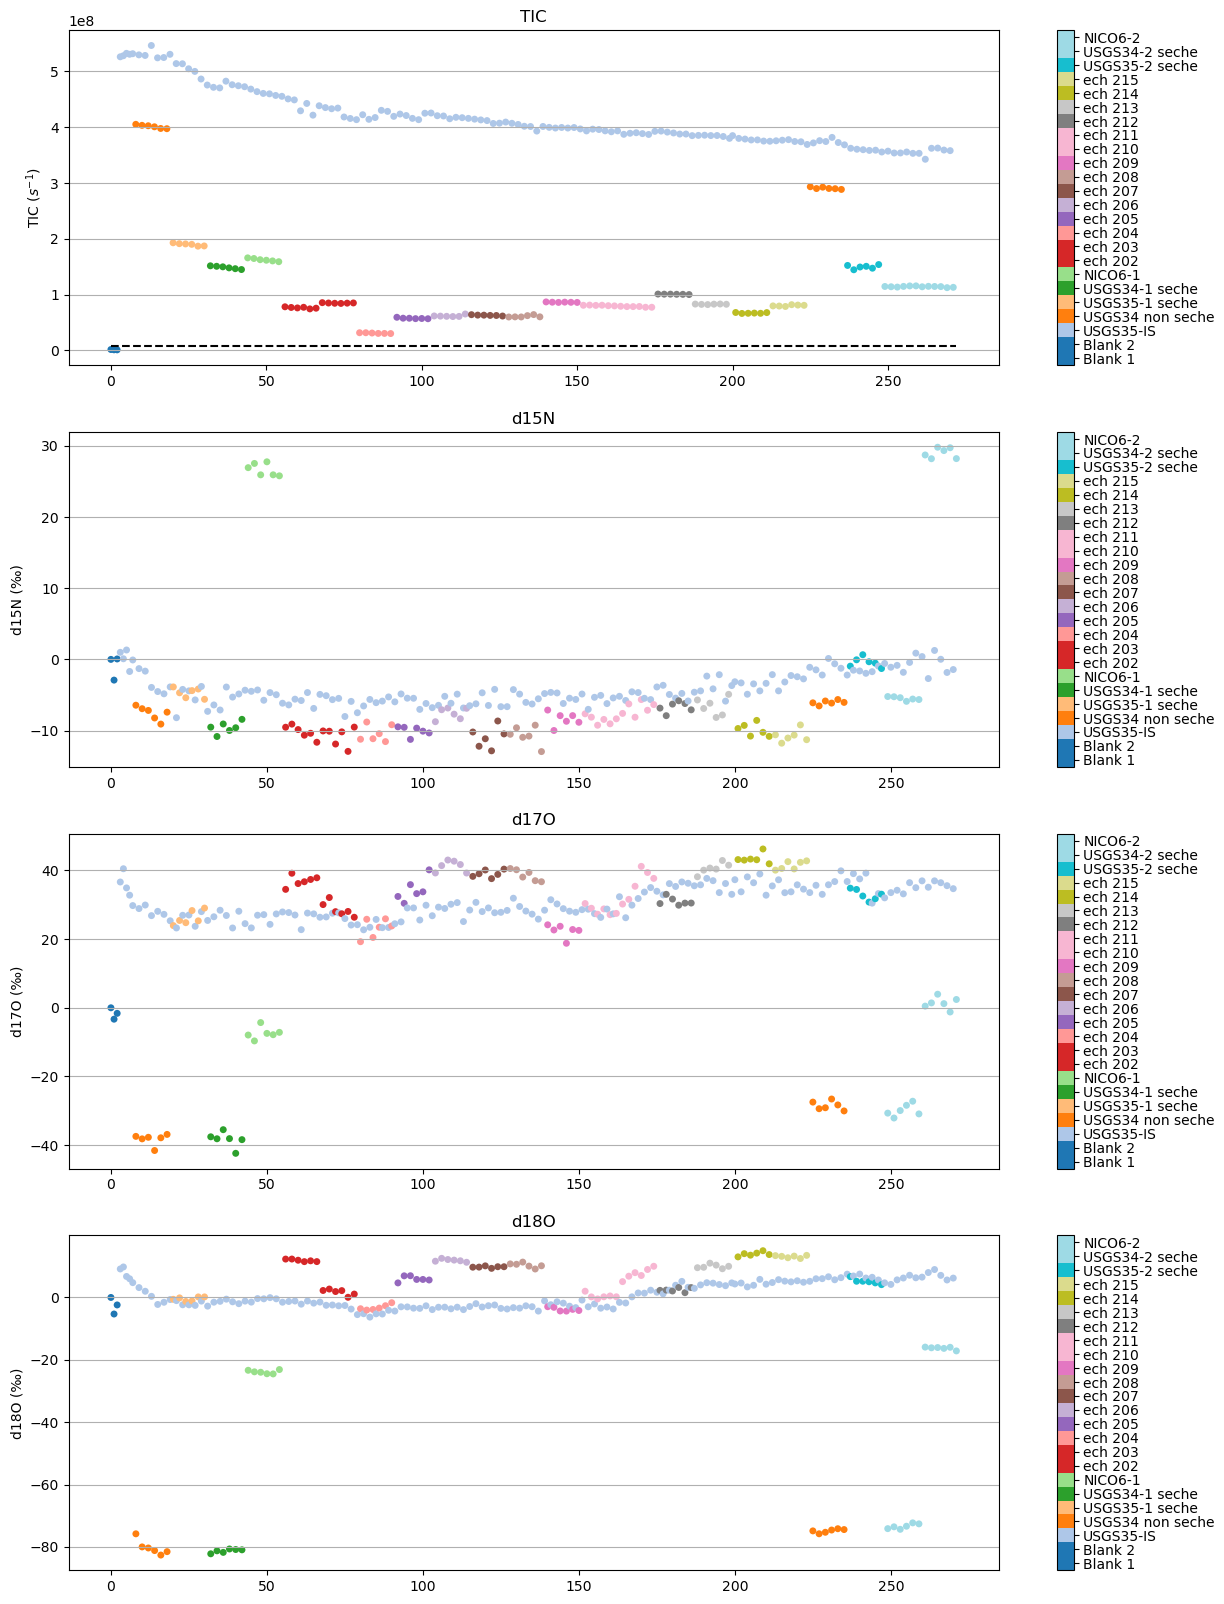

In [131]:
# calculate limit TIC
lim_TIC = 1e6*AGC/microscan_dur_sec
print('TIC must exceed '+f"{lim_TIC:.3g}"+ ' ions/s')

summ = pd.read_csv(os.path.join(path, outputpath, [string for string in os.listdir(os.path.join(path,outputpath)) if string.split('_')[-2]=='summary' ][0]))

filenames = summ['filename']
rcols = ratio_df.columns[[col.startswith('Ratio') for col in ratio_df.columns]]

fig,ax = plt.subplots(1+len(rcols), figsize=[15,5*(1+len(rcols))])

categories = summ['sample_name']

from matplotlib.colors import ListedColormap
tab10_cmap = plt.get_cmap('tab20')
colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
discrete_cmap = ListedColormap(colors)

category_mapping = {category: i for i, category in enumerate(categories.unique())}
numeric_categories = np.array([category_mapping[category] for category in categories])

# TIC plot
scatter = ax[0].scatter(summ.index, summ['TIC_av'], c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=100)
cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
cbar.set_ticklabels(categories.unique())
ax[0].plot([0,len(summ)],[lim_TIC,lim_TIC], '--',c='k')
# ax[0].set_yscale('log')
ax[0].grid(True, axis='y')
ax[0].set_ylabel('TIC ($s^{-1}$)')
ax[0].set_title('TIC')

# isotopologue ratio plots
for i,col in enumerate(rcols):
    j=i+1
    scatter = ax[j].scatter(summ.index, (summ[col]/summ.loc[0,col]-1)*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.', s=100)
    cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) )+ 1) - 0.5)
    cbar.set_ticklabels(categories.unique())
    ax[j].grid(True, axis='y')
    ax[j].set_ylabel('d' + col.split('_')[-1] + ' (‰)')
    ax[j].set_title('d' + col.split('_')[-1])



### Plot TIC and $\delta^{18}O$ curves for each sample
Set plots = True to see plots  

/var/folders/rr/bz6rnlcn09b6b2ttxx8h8x5m0000gn/T/ipykernel_51603/2139260708.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(2, figsize = [10,4])


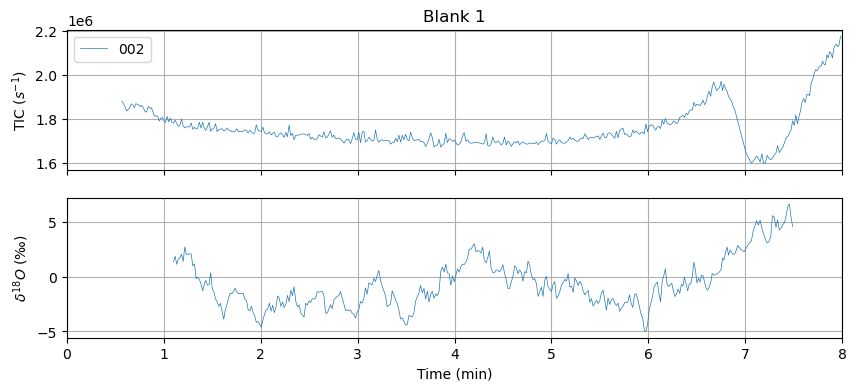

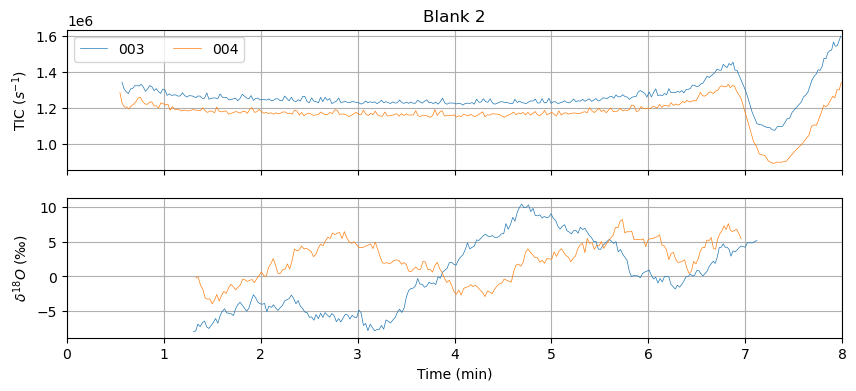

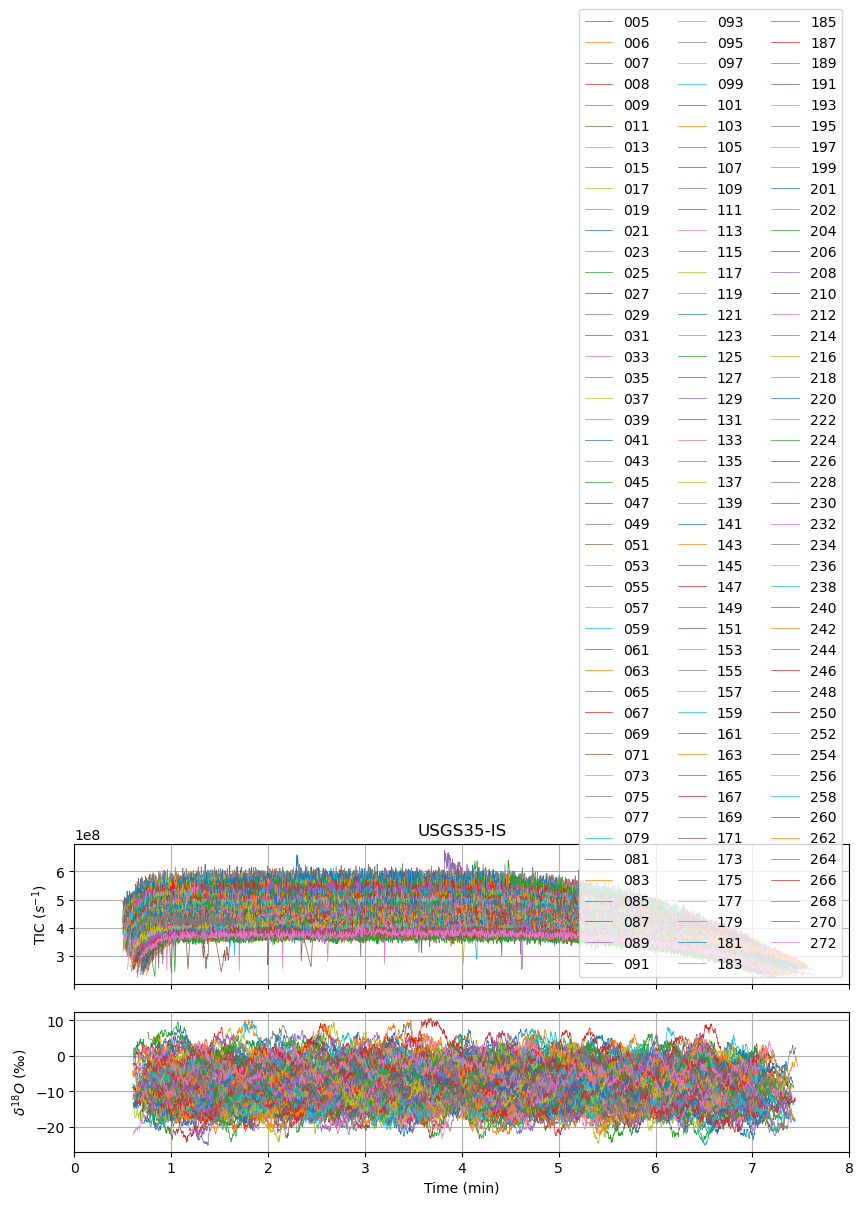

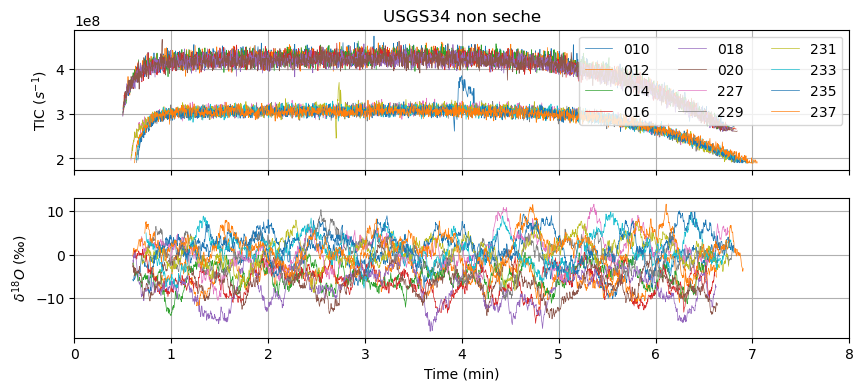

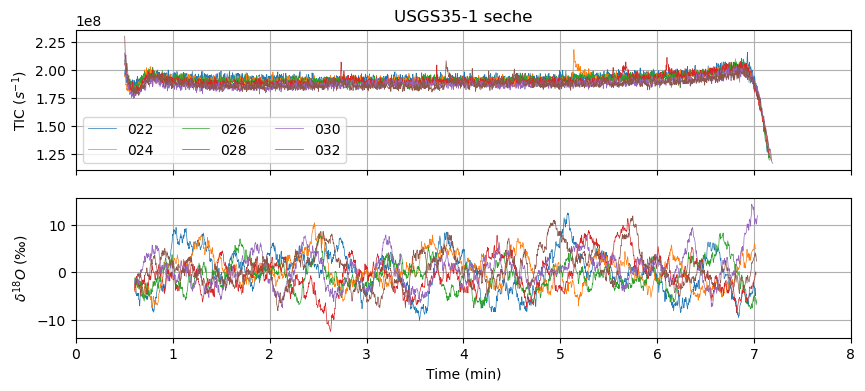

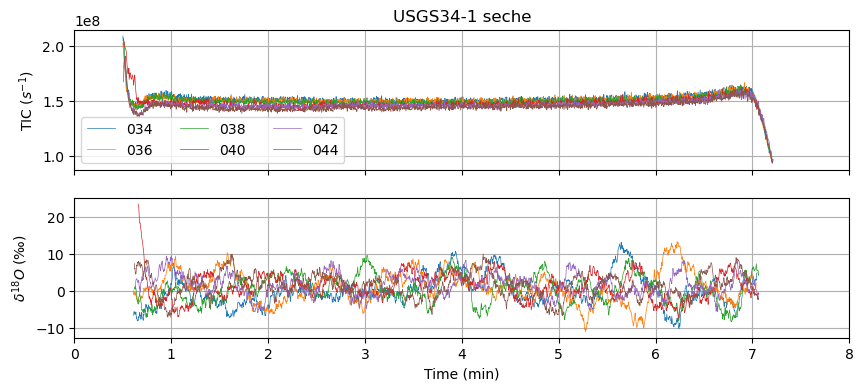

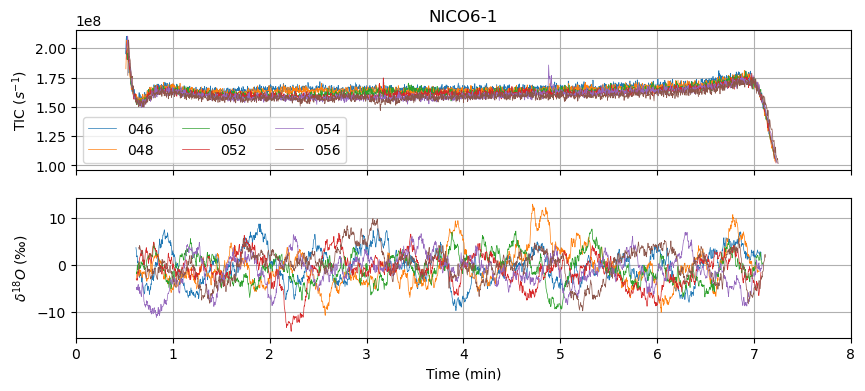

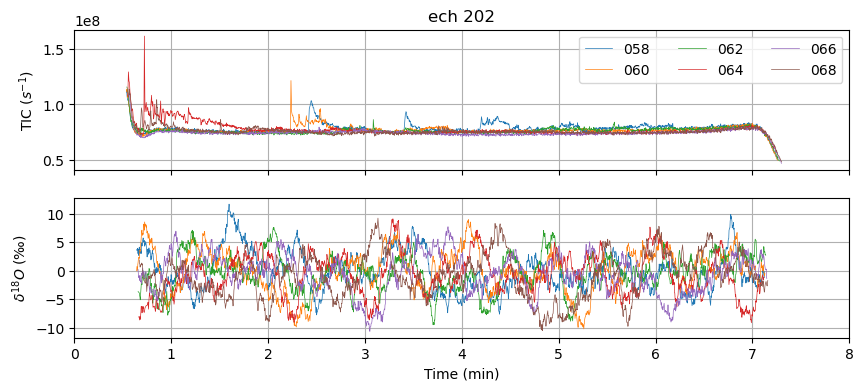

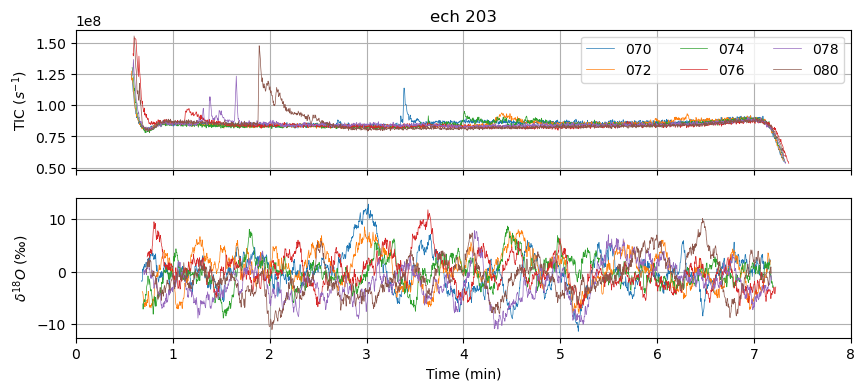

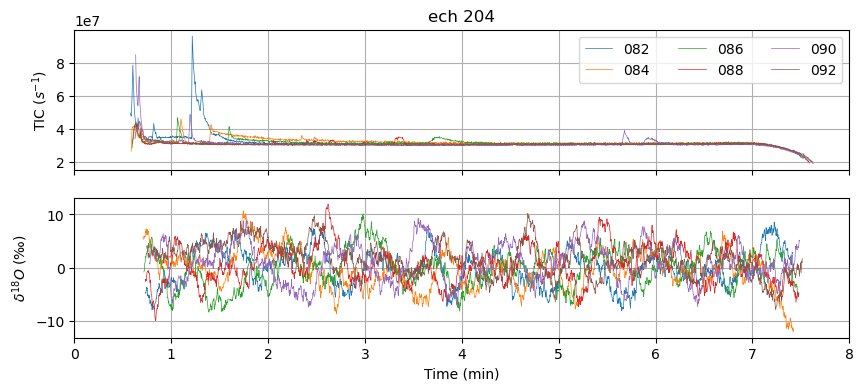

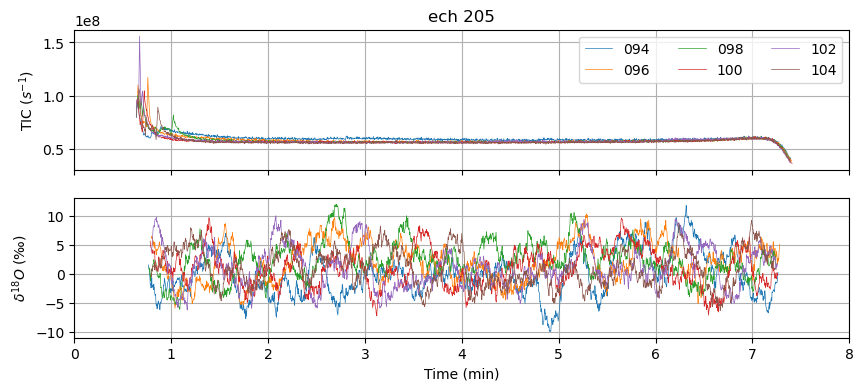

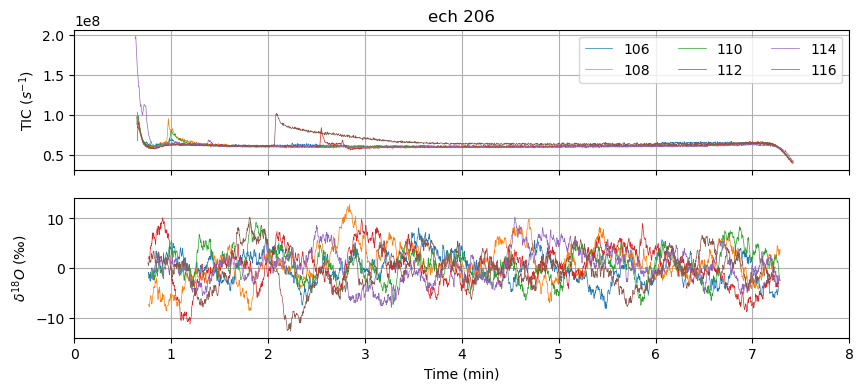

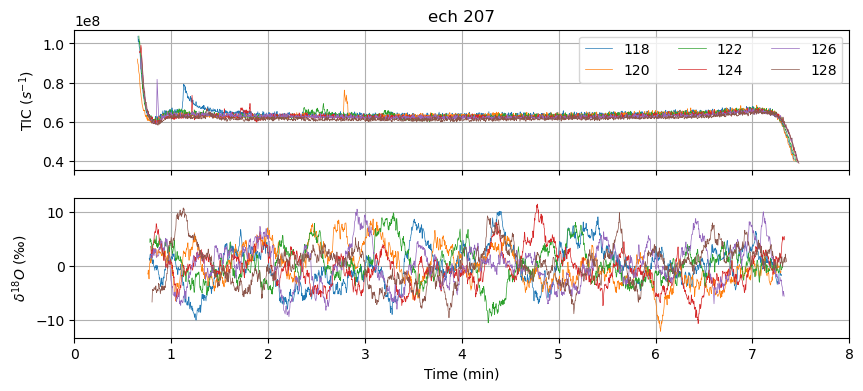

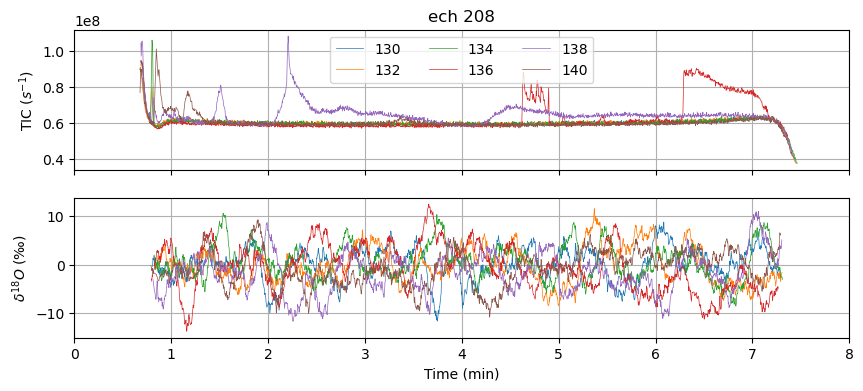

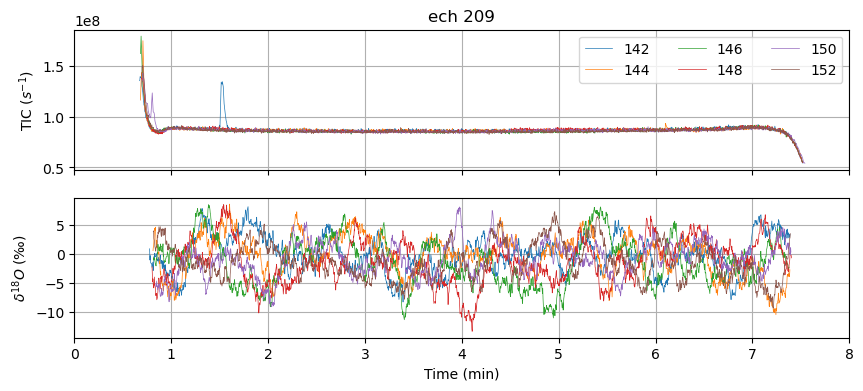

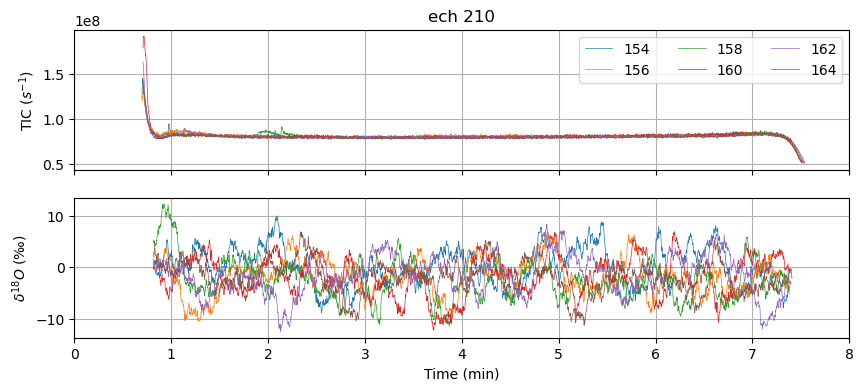

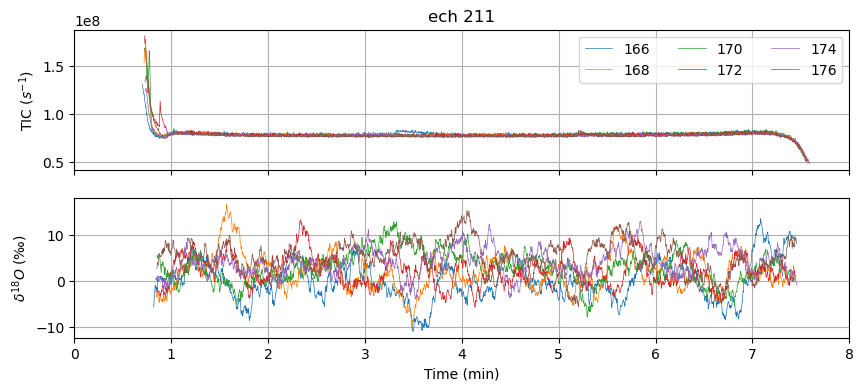

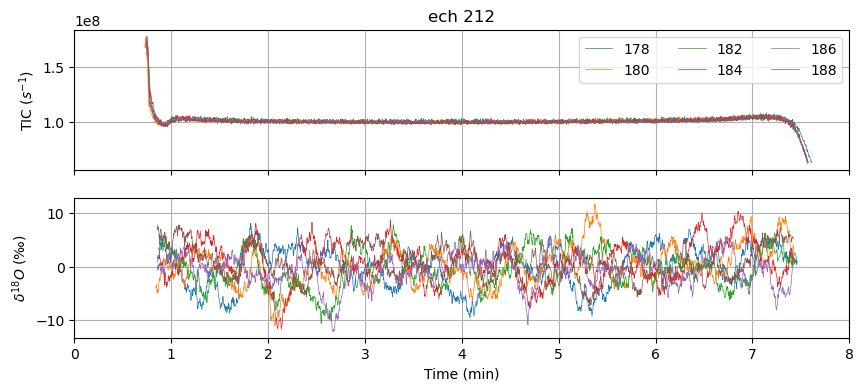

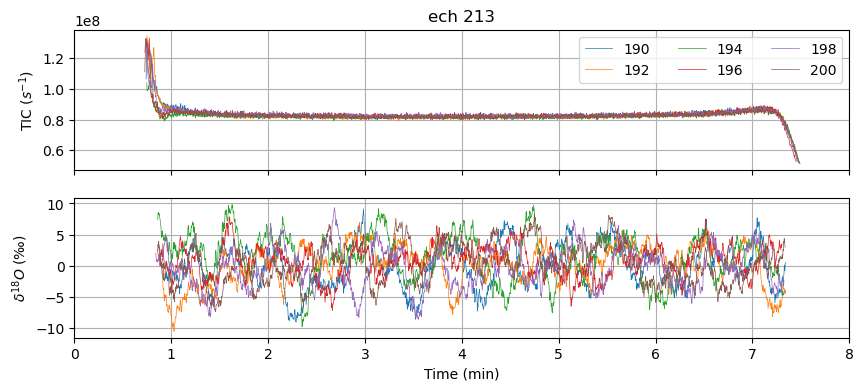

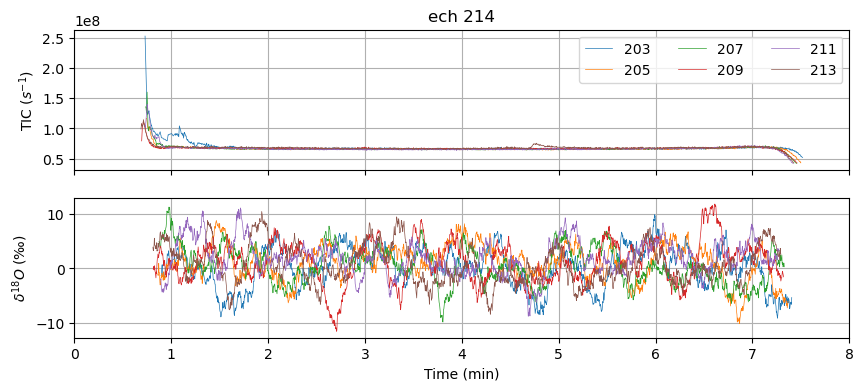

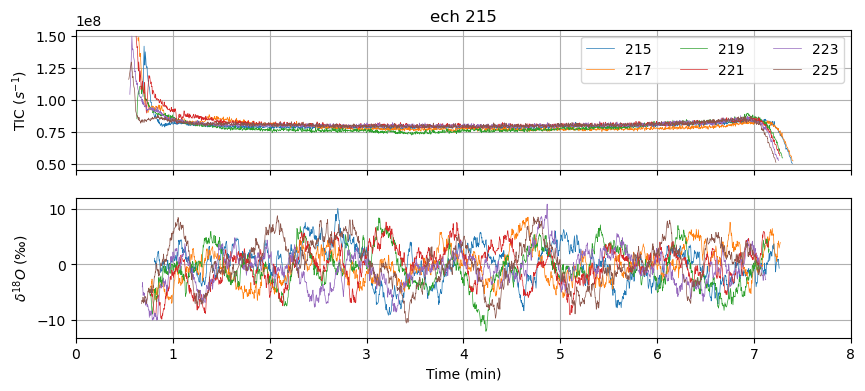

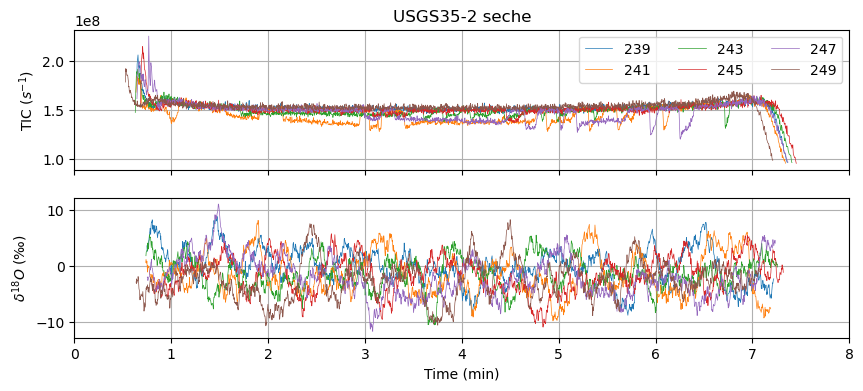

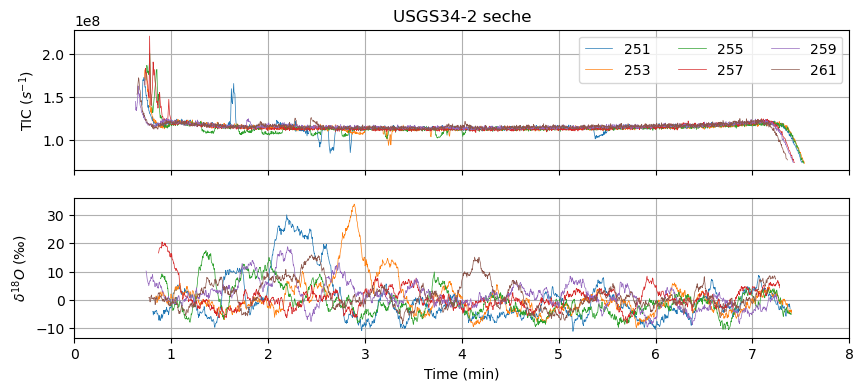

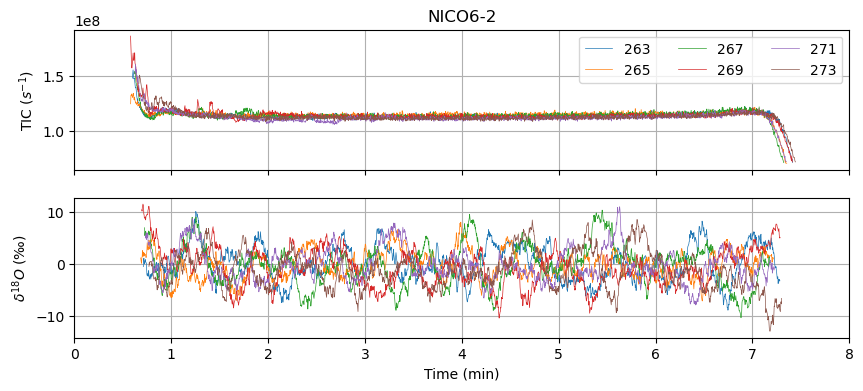

In [132]:
plots = True

# load metadata.csv
summ = pd.read_csv(os.path.join(path,outputpath,[s for s in os.listdir(os.path.join(path,outputpath)) if s.endswith('_summary_nonfiltered.csv')][0]))

sample_names = np.array([x for x in summ['sample_name'].unique()])

for i, sample in enumerate(sample_names):
    if plots == True:
        fig,ax = plt.subplots(2, figsize = [10,4])
        samplefilenames = summ[summ['sample_name']==sample]['filename']

            
        ref_18O = pd.read_csv(os.path.join(path,outputpath,samplefilenames.iloc[0]))['Ratio_18O'].mean()
        
        for j, sam in enumerate(samplefilenames):

            data = pd.read_csv(os.path.join(path,outputpath,sam))
            scandur = 0.003
            meandur = 0.2
            window_size = int(meandur / scandur)
            data[['Rolling_18O']] = data[['Ratio_18O']].rolling(window=window_size, center=True).mean()

            ax[0].set_title(data['sample.name'].iloc[0])

            ax[0].plot(data['time.min'],data['tic'], label=sam.split('_')[1], lw=0.5)
            ax[0].set_xlim([0, 8])
            ax[0].grid(True,axis='both')
            ax[0].set_ylabel('TIC ($s^{-1}$)')
            ax[0].legend(ncols=3)        
            ax[0].set_xticklabels([])


            ax[1].plot(data['time.min'],1000*(data['Rolling_18O']/ref_18O-1), lw=0.5)
            ax[1].set_xlim(ax[0].get_xlim())
            ax[1].grid(True,axis='both')
            ax[1].set_ylabel('$\delta^{18}O$ (‰)')

            ax[-1].set_xlabel('Time (min)')

### Injection filtering
Remove unfaithful injections using filters or by hand   
Saves a filtered summary file '_summary_filtered.csv'

In [133]:
print('List of the first occurence of each sample name')
summ['sample_name'].drop_duplicates()

List of the first occurence of each sample name


0               Blank 1
1               Blank 2
3             USGS35-IS
8      USGS34 non seche
20       USGS35-1 seche
32       USGS34-1 seche
44              NICO6-1
56              ech 202
68              ech 203
80              ech 204
92              ech 205
104             ech 206
116             ech 207
128             ech 208
140             ech 209
152             ech 210
164             ech 211
176             ech 212
188             ech 213
201             ech 214
213             ech 215
237      USGS35-2 seche
249      USGS34-2 seche
261             NICO6-2
Name: sample_name, dtype: object

In [135]:
summ_filt = summ.copy()

# Remove all injections after a given one 
if False:
    removefrom = 140     # specify start of set to be removed here
    toremove = summ_filt.iloc[removefrom:]
    print('Removed '+str(len(toremove)) + ' injections after #'+str(removefrom)+': \n'+ str(list(toremove.index)))
    summ_filt = summ_filt[~summ_filt.isin(toremove)].dropna(how='all')

# blank filter
toremove = summ_filt[summ_filt['sample_name'].str.startswith('Blank')]
print('Removed '+str(len(toremove)) + ' blank injections: \n'+ str(list(toremove.index)))
summ_filt = summ_filt[~summ_filt.isin(toremove)].dropna(how='all')

# minimum TIC filter
if True:
    toremove = summ_filt[summ_filt['TIC_av']<lim_TIC]
    print('Removed '+str(len(toremove)) + ' further injections with TIC<'+f'{lim_TIC:.3g}: \n'+ str(list(toremove.index)))
    summ_filt = summ_filt[~summ_filt.isin(toremove)].dropna(how='all')

# Other injection numbers to remove manually
remove = []
toremove = summ_filt.iloc[remove]
print('Removed '+str(len(toremove)) + ' addional injections: \n'+ str(list(toremove.index)))
summ_filt = summ_filt[~summ_filt.isin(toremove)].dropna(how='all')

# Display remaining injection numbers
print(str(len(summ_filt))+' injections remain: \n' +str(list(summ_filt.index)))

# export filtered summary file as csv
summ_filt.to_csv(os.path.join(path, outputpath,fn.split('_')[0]+'_summary_filtered.csv'))
print('Saved summary file as ' + os.path.join(path, outputpath,fn.split('_')[0]+'_summary_filtered.csv.'))

Removed 3 blank injections: 
[0, 1, 2]
Removed 0 further injections with TIC<8.33e+06: 
[]
Removed 0 addional injections: 
[]
269 injections remain: 
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193

## 3. Bracketing
Uses brackting formula: $\delta = \frac{2R_i}{R_{i-1}+R_{i+1}}-1$ to calculate internal deltas for each isotopologue for every sample which is surrounded by internal standards.  
- Saves internal deltas as 'internal_deltas_YYYY-MM-DD.csv'.  
- Saves summary as 'internal_deltas_summary_YYYY-MM-DD.csv' with mean and sem for each isotopologue for each sample.

Bracketed internal delta values relative to basepeak saved as 240208_CdD_202-215_M0/internal_deltas_2024-02-28.csv
Summarised ouptut saved as 240208_CdD_202-215_M0/internal_deltas_summary_2024-02-28.csv


mean_d15N mean_d17O mean_d18O  err_d15N  err_d17O  err_d18O
sample_name                                                                 
NICO6-1           0.031686 -0.032422 -0.023215  0.000330  0.000571  0.000401
NICO6-2           0.029922 -0.033609 -0.023126  0.000443  0.000588  0.000473
USGS34 non seche   -0.0047 -0.063429 -0.080687  0.000223  0.000666  0.000236
USGS34-1 seche   -0.004034 -0.063057 -0.079959  0.000376  0.000763  0.000243
USGS34-2 seche   -0.004926 -0.062216 -0.078786  0.000367  0.000646  0.000293
USGS35-1 seche    0.000638  0.000406  0.001399  0.000467  0.000762  0.000285
USGS35-2 seche    0.001109 -0.002648 -0.001303  0.000406  0.000957  0.000209
ech 202          -0.004408  0.010103  0.013416  0.000447  0.000769  0.000101
ech 203          -0.004741  0.002427  0.004609  0.000566  0.000725  0.000352
ech 204          -0.004395 -0.000691  0.001989  0.000481  0.001217  0.000127
ech 205          -0.004185  0.006757  0.009283  0.000358  0.001110  0.000289
ech 206          -0.001575  0.012251  0.015333  0.000351  0.000377  0.000143
ech 207          -0.005144  0.010142  0.012629  0.000720  0.000572  0.000246
ech 208          -0.005253  0.009871  0.013578  0.000596  0.000365  0.000310
ech 209          -0.003178 -0.006533 -0.001715  0.000472  0.000717  0.000292
ech 210          -0.002813  0.000162  0.003188  0.000356  0.000610  0.000272
ech 211          -0.001755  0.004143  0.007038  0.000414  0.000980  0.000333
ech 212          -0.001883 -0.004204 -0.000578  0.000501  0.000721  0.000548
ech 213          -0.002769  0.004703  0.005765  0.000734  0.000875  0.000178
ech 214           -0.00624  0.007131  0.009471  0.000491  0.000682  0.000236

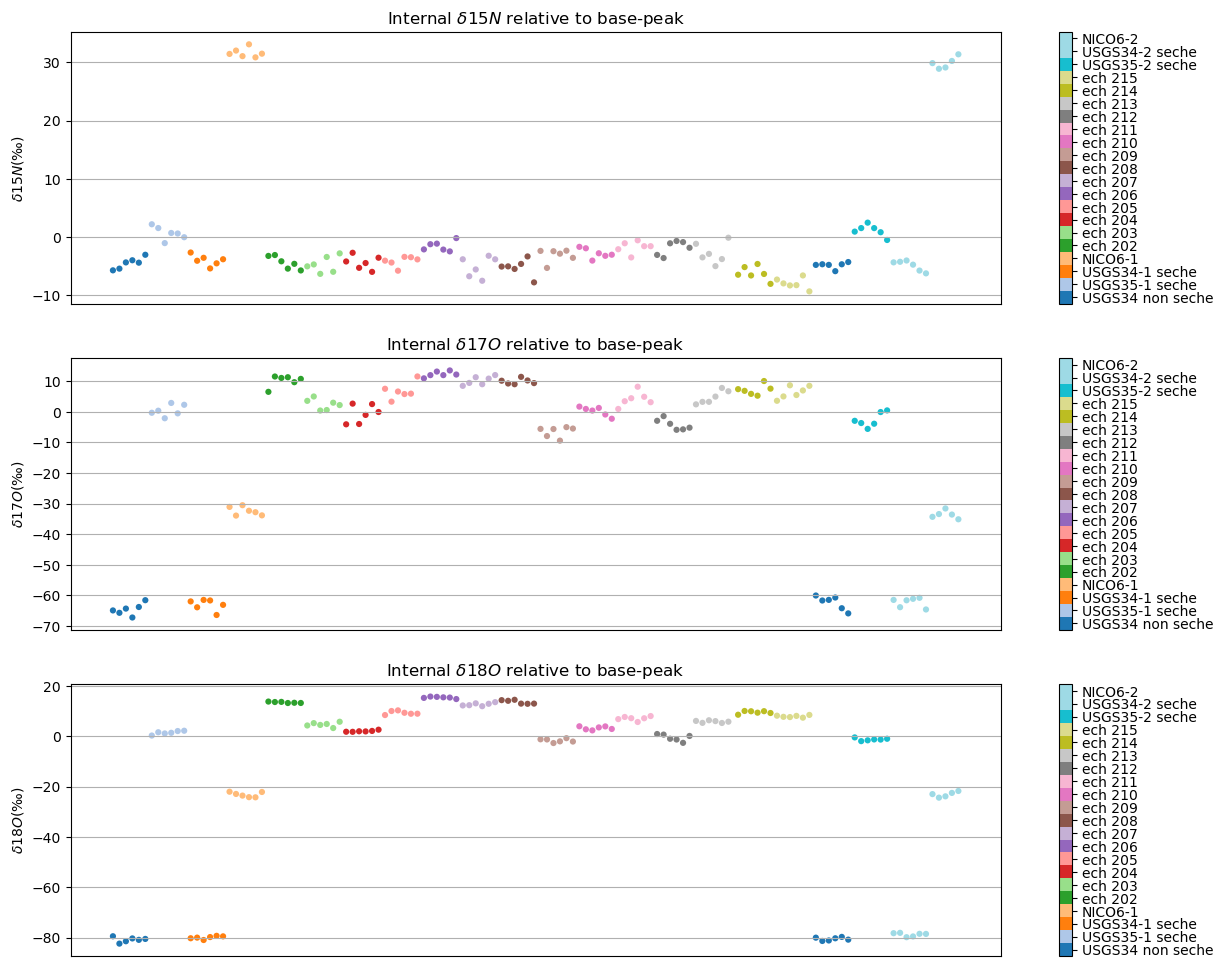

In [136]:
# identify isotopologs
isotopologues = [col.split('_')[1] for col in summ_filt.columns if col.split('_')[0]=='Ratio']
    
# identify sample injections
samples = summ_filt[summ_filt['sample_name'] != internal_std]
samples_delta = pd.DataFrame(columns=['sample_name','experiment']+['d'+iso for iso in isotopologues]+['rel_to'],index = samples.index)
samples_delta.loc[:,'sample_name']=samples.loc[:,'sample_name']
samples_delta.loc[:,'experiment']=samples.loc[:,'experiment']

# bracketing
for i in samples.index:
    if i-1 in summ_filt.index and i+1 in summ_filt.index:
        if summ_filt.loc[i-1,'sample_name']==internal_std and summ_filt.loc[i+1,'sample_name']==internal_std:
            R_i = summ_filt.loc[i,['Ratio_'+iso for iso in isotopologues]]
            R_minus = summ_filt.loc[i-1,['Ratio_'+iso for iso in isotopologues]]
            R_plus = summ_filt.loc[i+1,['Ratio_'+iso for iso in isotopologues]]
            deltas = 2*R_i/(R_minus+R_plus)-1
            samples_delta.loc[i,['d'+iso for iso in isotopologues]] =deltas.tolist()

    samples_delta.loc[i,'rel_to'] = internal_std
samples_delta.dropna(how='all',subset=['d'+iso for iso in isotopologues],inplace=True)

# save
samples_delta.to_csv(os.path.join(path,'internal_deltas_'+current_date_string+'.csv'))
print('Bracketed internal delta values relative to basepeak saved as '+ os.path.join(path,'internal_deltas_'+current_date_string+'.csv'))

# summarise internal deltas per sample
stats=pd.DataFrame()
stats['sample_name']=samples_delta.groupby('sample_name')[['d'+iso for iso in isotopologues]].mean().reset_index()['sample_name']
stats[['mean_d'+iso for iso in isotopologues]]=samples_delta.groupby('sample_name')[['d'+iso for iso in isotopologues]].mean().reset_index()[['d'+iso for iso in isotopologues]]
stats[['err_d'+iso for iso in isotopologues]]=samples_delta.groupby('sample_name')[['d'+iso for iso in isotopologues]].sem().reset_index()[['d'+iso for iso in isotopologues]]
# put sample name as index
stats.index=stats['sample_name']
stats.drop('sample_name',axis=1,inplace=True)

    # plot
if True:
    fig,ax = plt.subplots(len(isotopologues), figsize=[15,4*len(isotopologues)])

    categories = samples_delta['sample_name']
    from matplotlib.colors import ListedColormap
    tab10_cmap = plt.get_cmap('tab20')
    colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
    discrete_cmap = ListedColormap(colors)
    category_mapping = {category: i for i, category in enumerate(categories.unique())}
    numeric_categories = np.array([category_mapping[category] for category in categories])

    for i,iso in enumerate(isotopologues):
        scatter = ax[i].scatter(samples_delta.index, samples_delta['d'+iso]*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=80)
        cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories)) + 1) - 0.5)
        cbar.set_ticklabels(categories.unique())
        ax[i].grid(True, axis='y')
        ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
        ax[i].set_title('Internal $\delta' + iso +'$ relative to base-peak')
        ax[i].set_xticks([])

        
# save
stats.to_csv(os.path.join(path,'internal_deltas_summary_'+current_date_string+'.csv'))
print('Summarised ouptut saved as '+os.path.join(path,'internal_deltas_summary_'+current_date_string+'.csv'))

# display
stats.head(20)

## 4. Change of reference of M1-based deltas to M0 (if applicable)
Uses change of reference formula: $\delta_{M2/M0} = \delta_{M2/M1} + \delta_{M1/M0} + \delta_{M2/M1}\times\delta_{M1/M0}$ and Orbitrap internal deltas of corresponding M0 sequence found at the path input at the top of script.  
This will only change deltas relative to the no-M0 basepeak (input at top of script).

Previously saved files are overwritten:
- Saves internal deltas as 'internal_deltas_YYYY-MM-DD.csv'.
- Saves summary as 'internal_deltas_summary_YYYY-MM-DD.csv' with mean and sem for each isotopologue for each sample.


In [137]:
df = pd.read_csv(noM0input)

dM1=pd.DataFrame()
dM1['sample_name']=df.groupby('sample_name')['d'+basepeak].mean().reset_index()['sample_name']
dM1['mean_d'+basepeak]=df.groupby('sample_name')['d'+basepeak].mean().reset_index()['d'+basepeak]
dM1['sem_d'+basepeak]=df.groupby('sample_name')['d'+basepeak].sem().reset_index()['d'+basepeak]

print('Found the following delta M1/M0 values at '+noM0input)
dM1

Found the following delta M1/M0 values at 240208_CdD_202-215_M0/internal_deltas_2024-02-14.csv


sample_name  mean_d15N  sem_d15N
0            NICO6-1   0.031686  0.000330
1            NICO6-2   0.029922  0.000443
2   USGS34 non seche  -0.004700  0.000223
3     USGS34-1 seche  -0.004034  0.000376
4     USGS34-2 seche  -0.004926  0.000367
5     USGS35-1 seche   0.000638  0.000467
6     USGS35-2 seche   0.001109  0.000406
7            ech 202  -0.004408  0.000447
8            ech 203  -0.004741  0.000566
9            ech 204  -0.004395  0.000481
10           ech 205  -0.004185  0.000358
11           ech 206  -0.001575  0.000351
12           ech 207  -0.005144  0.000720
13           ech 208  -0.005253  0.000596
14           ech 209  -0.003178  0.000472
15           ech 210  -0.002813  0.000356
16           ech 211  -0.001755  0.000414
17           ech 212  -0.001883  0.000501
18           ech 213  -0.002769  0.000734
19           ech 214  -0.006240  0.000491
20           ech 215  -0.007997  0.000383

In [138]:
delta_changed = samples_delta.copy()
for i in samples_delta.index:
    if samples_delta.loc[i,'experiment'].split('_')[-1]=='noM0':
        if samples_delta.loc[i,'sample_name'] in dM1['sample_name'].values:
            index_in_dM1 = dM1[dM1['sample_name'] == samples_delta.loc[i,'sample_name']].index[0]
            
            d1 = dM1.loc[index_in_dM1,'mean_d'+basepeak]
            d2 = samples_delta.loc[i, ['d'+iso for iso in isotopologues]]
            
            delta_changed.loc[i,['d'+iso for iso in isotopologues]] = d1+d2+d1*d2

delta_changed.to_csv(os.path.join(path,'internal_deltas_'+current_date_string+'.csv'))
print('Changed reference of no-M0 sample delta values to M0. Output saved as '+os.path.join(path,'internal_deltas_'+current_date_string+'.csv'))

# summarise m0-based internal deltas per sample
stats_changed=pd.DataFrame()
stats_changed['sample_name']=delta_changed.groupby('sample_name')[['d'+iso for iso in isotopologues]].mean().reset_index()['sample_name']
stats_changed[['mean_d'+iso for iso in isotopologues]]=delta_changed.groupby('sample_name')[['d'+iso for iso in isotopologues]].mean().reset_index()[['d'+iso for iso in isotopologues]]
stats_changed[['err_d'+iso for iso in isotopologues]]=delta_changed.groupby('sample_name')[['d'+iso for iso in isotopologues]].sem().reset_index()[['d'+iso for iso in isotopologues]]
# put sample name as index
stats_changed.index=stats_changed['sample_name']
stats_changed.drop('sample_name',axis=1,inplace=True)

# plot
if False:
    fig,ax = plt.subplots(len(isotopologues), figsize=[15,4*len(isotopologues)])

    categories = delta_changed['sample_name']
    from matplotlib.colors import ListedColormap
    tab10_cmap = plt.get_cmap('tab20')
    colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
    discrete_cmap = ListedColormap(colors)
    category_mapping = {category: i for i, category in enumerate(categories.unique())}
    numeric_categories = np.array([category_mapping[category] for category in categories])

    for i,iso in enumerate(isotopologues):
        scatter = ax[i].scatter(delta_changed.index, delta_changed['d'+iso]*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=80)
        cbar = plt.colorbar(scatter, ticks=pd.Series(numeric_categories).unique(), boundaries=np.arange(len(pd.Series(numeric_categories).unique() + 1)) + 0.5)
        cbar.set_ticklabels(pd.Series(categories).unique())
        ax[i].grid(True, axis='y')
        ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
        ax[i].set_title('Internal $\delta' + iso +'$ relative to $M_0$')
        ax[i].set_xticks([])

# save
stats_changed.to_csv(os.path.join(path,'internal_deltas_summary_'+current_date_string+'.csv'))
print('Summarised ouptut saved as '+os.path.join(path,'internal_deltas_summary_'+current_date_string+'.csv'))

# display
stats_changed.head(20)

Changed reference of no-M0 sample delta values to M0. Output saved as 240208_CdD_202-215_M0/internal_deltas_2024-02-28.csv
Summarised ouptut saved as 240208_CdD_202-215_M0/internal_deltas_summary_2024-02-28.csv


mean_d15N mean_d17O mean_d18O  err_d15N  err_d17O  err_d18O
sample_name                                                                 
NICO6-1           0.031686 -0.032422 -0.023215  0.000330  0.000571  0.000401
NICO6-2           0.029922 -0.033609 -0.023126  0.000443  0.000588  0.000473
USGS34 non seche   -0.0047 -0.063429 -0.080687  0.000223  0.000666  0.000236
USGS34-1 seche   -0.004034 -0.063057 -0.079959  0.000376  0.000763  0.000243
USGS34-2 seche   -0.004926 -0.062216 -0.078786  0.000367  0.000646  0.000293
USGS35-1 seche    0.000638  0.000406  0.001399  0.000467  0.000762  0.000285
USGS35-2 seche    0.001109 -0.002648 -0.001303  0.000406  0.000957  0.000209
ech 202          -0.004408  0.010103  0.013416  0.000447  0.000769  0.000101
ech 203          -0.004741  0.002427  0.004609  0.000566  0.000725  0.000352
ech 204          -0.004395 -0.000691  0.001989  0.000481  0.001217  0.000127
ech 205          -0.004185  0.006757  0.009283  0.000358  0.001110  0.000289
ech 206          -0.001575  0.012251  0.015333  0.000351  0.000377  0.000143
ech 207          -0.005144  0.010142  0.012629  0.000720  0.000572  0.000246
ech 208          -0.005253  0.009871  0.013578  0.000596  0.000365  0.000310
ech 209          -0.003178 -0.006533 -0.001715  0.000472  0.000717  0.000292
ech 210          -0.002813  0.000162  0.003188  0.000356  0.000610  0.000272
ech 211          -0.001755  0.004143  0.007038  0.000414  0.000980  0.000333
ech 212          -0.001883 -0.004204 -0.000578  0.000501  0.000721  0.000548
ech 213          -0.002769  0.004703  0.005765  0.000734  0.000875  0.000178
ech 214           -0.00624  0.007131  0.009471  0.000491  0.000682  0.000236

## 5. Conversion of internal deltas to international scale based on values of internal standard
Reference delta values of internal standard are taken from the reference data (inputs at top of script).  

Saves external deltas:
- Saves external deltas as 'external_deltas_YYYY-MM-DD.csv'.
- Saves summary as 'external_deltas_summary_YYYY-MM-DD.csv' with mean and sem for each isotopologue for each sample.


Imported reference data for internal standard USGS35 from references_nitrate.xlsx
   mean_d15N  mean_d17O  mean_d18O
1     0.0027     0.0515     0.0575
Changed reference of internal deltas to international reference scale. Output saved as 240208_CdD_202-215_M0/external_deltas_2024-02-28.csv
Summarised ouptut saved as 240208_CdD_202-215_M0/external_deltas__summary2024-02-28.csv


mean_d15N mean_d17O mean_d18O  err_d15N  err_d17O  err_d18O
sample_name                                                                 
NICO6-1           0.034472  0.017408   0.03295  0.000331  0.000600  0.000424
NICO6-2           0.032702  0.016161  0.033044  0.000445  0.000619  0.000500
USGS34 non seche -0.002012 -0.015196 -0.027826  0.000223  0.000700  0.000250
USGS34-1 seche   -0.001345 -0.014804 -0.027056  0.000377  0.000803  0.000256
USGS34-2 seche   -0.002239  -0.01392 -0.025816  0.000368  0.000680  0.000310
USGS35-1 seche     0.00334  0.051927  0.058979  0.000468  0.000801  0.000301
USGS35-2 seche    0.003812  0.048715  0.056122  0.000407  0.001007  0.000221
ech 202           -0.00172  0.062123  0.071687  0.000448  0.000809  0.000107
ech 203          -0.002054  0.054052  0.062375  0.000568  0.000762  0.000372
ech 204          -0.001707  0.050774  0.059603  0.000482  0.001280  0.000134
ech 205          -0.001496  0.058605  0.067317  0.000359  0.001168  0.000305
ech 206           0.001121  0.064382  0.073715  0.000352  0.000397  0.000151
ech 207          -0.002457  0.062165  0.070855  0.000722  0.000601  0.000260
ech 208          -0.002567   0.06188  0.071859  0.000598  0.000383  0.000327
ech 209          -0.000486  0.044631  0.055686  0.000473  0.000754  0.000309
ech 210          -0.000121   0.05167  0.060872  0.000357  0.000641  0.000288
ech 211            0.00094  0.055857  0.064943  0.000415  0.001031  0.000352
ech 212           0.000812  0.047079  0.056889  0.000503  0.000758  0.000580
ech 213          -0.000076  0.056445  0.063596  0.000736  0.000920  0.000188
ech 214          -0.003557  0.058998  0.067516  0.000492  0.000718  0.000250
ech 215          -0.005319  0.058165  0.065818  0.000384  0.000866  0.000175

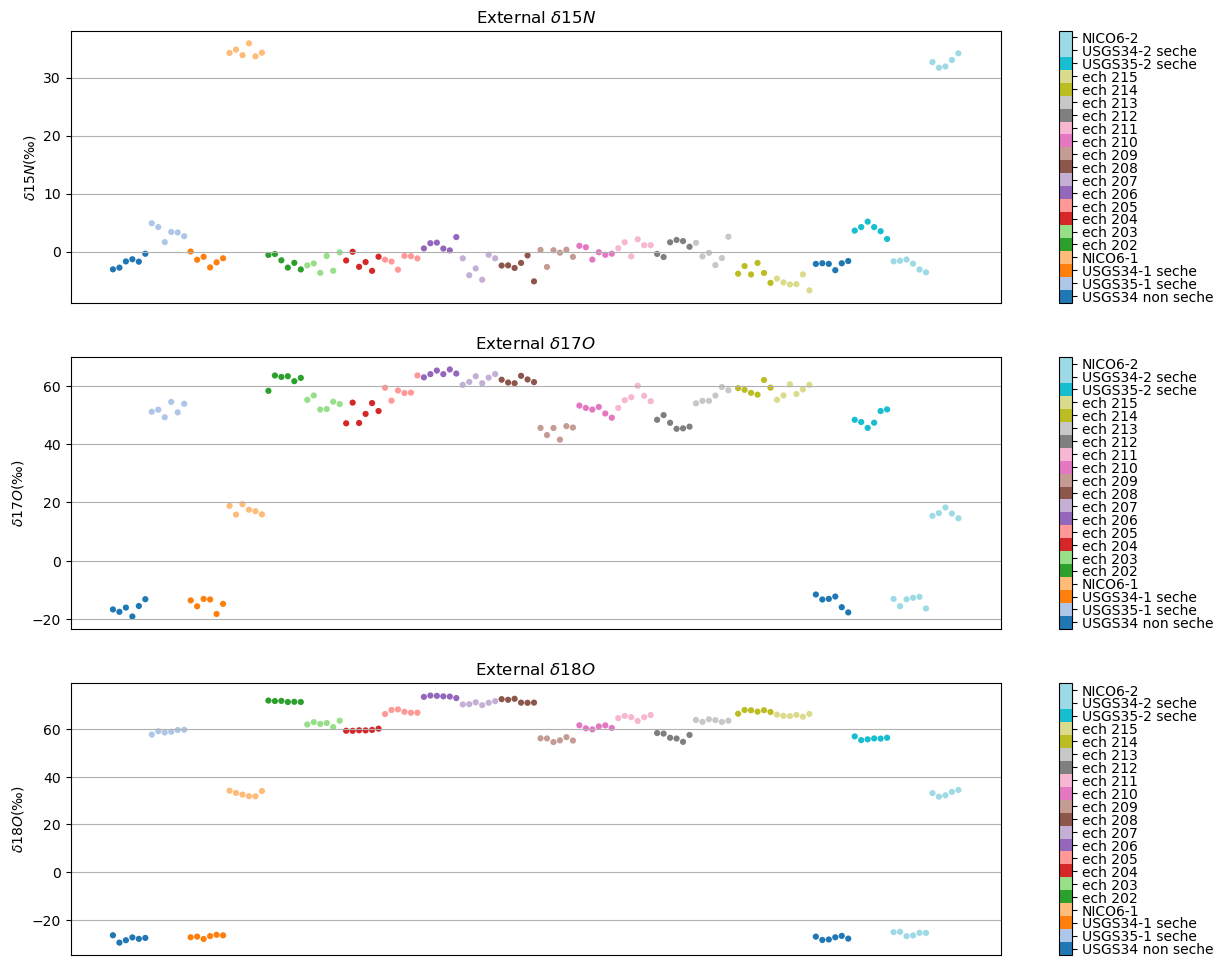

In [139]:
df = delta_changed.copy()

# Import reference data for internal standard
references = pd.read_excel(ref_filename)

internal_std_short = internal_std.split('-')[0]
refs_stats = references[references['sample_name']==internal_std_short]
refs_stats.loc[:,refs_stats.columns[1:]] = refs_stats.loc[:,refs_stats.columns[1:]]*1e-3

# display
print('Imported reference data for internal standard '+internal_std_short+' from '+ ref_filename)
print(refs_stats[['mean_d'+ iso for iso in isotopologues if 'mean_d'+ iso in refs_stats.columns]])

# identify isotopologues
isotopologs = [iso for iso in df.columns if iso.startswith('d')]

# change reference to international scale based on internal standard supposed values
df_international_scale=df.copy()
for i in df.index:
    # identify and rename the internal standard used
    int_std_name = df.loc[i,'rel_to']
    int_std_name = int_std_name.split('-')[0]
    # select internal standard delta vals
    if int_std_name in list(refs_stats['sample_name']):
        int_std_cols = ['mean_'+iso for iso in isotopologs  if 'mean_'+iso in refs_stats.columns ]
        int_std_deltas = refs_stats[refs_stats['sample_name']==int_std_name][int_std_cols]
         # correct using change of reference formula
        for col in int_std_deltas.columns:
            d1 = df.loc[i, col.split('_')[-1]] # internal delta for all samples
            d2 = int_std_deltas[col].iloc[0]  #delta of standard
            d_corr = d1 + d2 + d1*d2
            df_international_scale.loc[i, col.split('_')[-1]] = d_corr
        df_international_scale.loc[i,'rel_to'] = 'international reference'
    else:
        print("Couldn't find standard: "+ int_std_name+ ' in reference data. Using internal deltas for '+ str(df.loc[i,'sample_name']))

# save deltas as csv
df_international_scale.to_csv(os.path.join(path,'external_deltas_'+current_date_string+'.csv'))
print('Changed reference of internal deltas to international reference scale. Output saved as '+os.path.join(path,'external_deltas_'+current_date_string+'.csv'))

# plot
fig,ax = plt.subplots(len(isotopologues), figsize=[15,4*len(isotopologues)])

categories = df_international_scale['sample_name']
from matplotlib.colors import ListedColormap
tab10_cmap = plt.get_cmap('tab20')
colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
discrete_cmap = ListedColormap(colors)
category_mapping = {category: i for i, category in enumerate(categories.unique())}
numeric_categories = np.array([category_mapping[category] for category in categories])

for i,iso in enumerate(isotopologues):
    scatter = ax[i].scatter(df_international_scale.index, df_international_scale['d'+iso]*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.',s=80)
    cbar = plt.colorbar(scatter, ticks=pd.Series(numeric_categories).unique(), boundaries=np.arange(len(pd.Series(numeric_categories).unique() )+ 1) - 0.5)
    cbar.set_ticklabels(pd.Series(categories).unique())
    ax[i].grid(True, axis='y')
    ax[i].set_ylabel('$\delta' + iso + ' $(‰)')
    ax[i].set_title('External $\delta' + iso +'$')
    ax[i].set_xticks([])
    
# summary
stats=pd.DataFrame()
stats['sample_name']=df_international_scale.groupby('sample_name')[['d'+iso for iso in isotopologues]].mean().reset_index()['sample_name']
stats[['mean_d'+iso for iso in isotopologues]]=df_international_scale.groupby('sample_name')[['d'+iso for iso in isotopologues]].mean().reset_index()[['d'+iso for iso in isotopologues]].copy()
stats[['err_d'+iso for iso in isotopologues]]=df_international_scale.groupby('sample_name')[['d'+iso for iso in isotopologues]].sem().reset_index()[['d'+iso for iso in isotopologues]].copy()
# put sample name as index
stats.index=stats['sample_name']
stats.drop('sample_name',axis=1,inplace=True)

# save
stats.to_csv(os.path.join(path,'external_deltas_summary_'+current_date_string+'.csv'))
print('Summarised ouptut saved as '+os.path.join(path,'external_deltas__summary'+current_date_string+'.csv'))
# display
stats

In [140]:
stats.index=df_international_scale.groupby('sample_name')[['d'+iso for iso in isotopologues]].mean().reset_index()['sample_name']
stats[['mean_d'+iso for iso in isotopologues]]=df_international_scale.groupby('sample_name')[['d'+iso for iso in isotopologues]].mean().reset_index()[['d'+iso for iso in isotopologues]].copy()
stats[['err_d'+iso for iso in isotopologues]]=df_international_scale.groupby('sample_name')[['d'+iso for iso in isotopologues]].sem().reset_index()[['d'+iso for iso in isotopologues]].copy()
